# CIFAR 10 - Classifier

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from training_utils import *
from data_utils import *

%load_ext autoreload
%autoreload 2

## Generate the dataloader

cuda:0


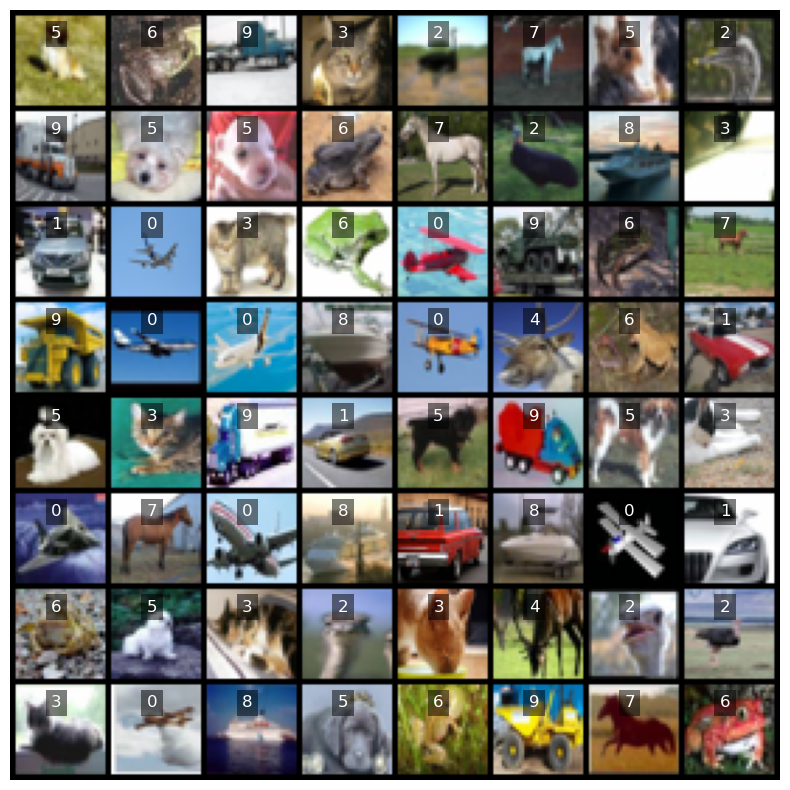

In [3]:
# First generation, no data augmentation
train_data, val_data = get_cifar10_dataloader()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

visualize_dataloader(train_data)

### Let's build the first simplest CNN

The architecture is fairly straightforward. The net begins with two convolutional layers, each followed by batch normalization (to help improve the network's learning capabilities) and a 2x2 max-pooling layer to reduce the spatial dimensions of the feature maps. The third and fourth convolutional layers are separated by only batch normalization and the activation function. Some research papers ([A Flexible-greedy Approach to find Well-tuned CNN Architecture for Image Recognition Problem](https://www.researchgate.net/publication/326816043_FAWCA_A_Flexible-greedy_Approach_to_find_Well-tuned_CNN_Architecture_for_Image_Recognition_Problem), [ResNet](https://arxiv.org/abs/1512.03385), and others) suggest configurations where convolutional layers aren't followed by pooling layers. This setup allows the network to potentially learn more abstract features from deeper intermediate representations. In this case, I’ve placed the pooling at the end to help enhance the learning process of the final (and smaller) representation of the data. The network concludes with fully connected (dense) layers to combine the learned features and classify the image.

A dropout layer with probability of 0.2 is added to hopefully reduce the overfitting.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, output_dim=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  

        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = SimpleCNN()
model = model.to('cuda')
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Linear-12                  [-1, 512]       2,097,664
          Dropout-13                  [-1, 512]               0
           Linear-14                  [

Let's train the network with 5 epochs, for different optimizer, to see which one is gives better performances. The interesting one are
- SGD (Stochastic Gradient Descent)
- SGD with momentum
- ADAM
- AdamW

For all the optimizer, the learning rate is fixed to 0.001

In [5]:
lr = 0.001
epochs = 5

# SGD without momentum
print("SGD without momentum")
model = SimpleCNN()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
loss_sgd, acc_sgd, acc_train_sgd = train_model(model, train_data, val_data, device, epochs=epochs, optimizer=optimizer)
print()

# SGD with momentum
print("SGD with momentum")
model = SimpleCNN()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_sgd_momentum, acc_sgd_momentum, acc_train_sgd_momentum = train_model(
    model, train_data, val_data, device, epochs=epochs, optimizer=optimizer
)
print()

# ADAM
print("ADAM")
model = SimpleCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_adam, acc_adam, acc_train_adam = train_model(
    model, train_data, val_data, device, epochs=epochs, optimizer=optimizer
)
print()

# ADAMW
print("ADAMW")
model = SimpleCNN()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_adamw, acc_adamw, acc_train_adamw = train_model(
    model, train_data, val_data, device, epochs=epochs, optimizer=optimizer
)

losses = [
    ("SGD", loss_sgd, acc_sgd, acc_train_sgd),
    ("SGD with momentum", loss_sgd_momentum, acc_sgd_momentum, acc_train_sgd_momentum),
    ("ADAM", loss_adam, acc_adam, acc_train_adam),
    ("ADAMW", loss_adamw, acc_adamw, acc_train_adamw),
]

SGD without momentum
[Epoch  1/5] Training Loss: 2.1992, Validation Accuracy: 33.18%, Training Accuracy: 32.84%, Time: 4.35s, lr: 0.001000
[Epoch  2/5] Training Loss: 1.9244, Validation Accuracy: 38.67%, Training Accuracy: 39.22%, Time: 4.04s, lr: 0.001000
[Epoch  3/5] Training Loss: 1.7346, Validation Accuracy: 42.59%, Training Accuracy: 43.23%, Time: 4.08s, lr: 0.001000
[Epoch  4/5] Training Loss: 1.6118, Validation Accuracy: 45.89%, Training Accuracy: 46.68%, Time: 4.03s, lr: 0.001000
[Epoch  5/5] Training Loss: 1.5148, Validation Accuracy: 48.76%, Training Accuracy: 49.42%, Time: 4.32s, lr: 0.001000

SGD with momentum
[Epoch  1/5] Training Loss: 1.6640, Validation Accuracy: 53.52%, Training Accuracy: 54.69%, Time: 4.27s, lr: 0.001000
[Epoch  2/5] Training Loss: 1.1986, Validation Accuracy: 62.23%, Training Accuracy: 64.32%, Time: 4.15s, lr: 0.001000
[Epoch  3/5] Training Loss: 0.9961, Validation Accuracy: 67.19%, Training Accuracy: 69.89%, Time: 4.42s, lr: 0.001000
[Epoch  4/5] Tra

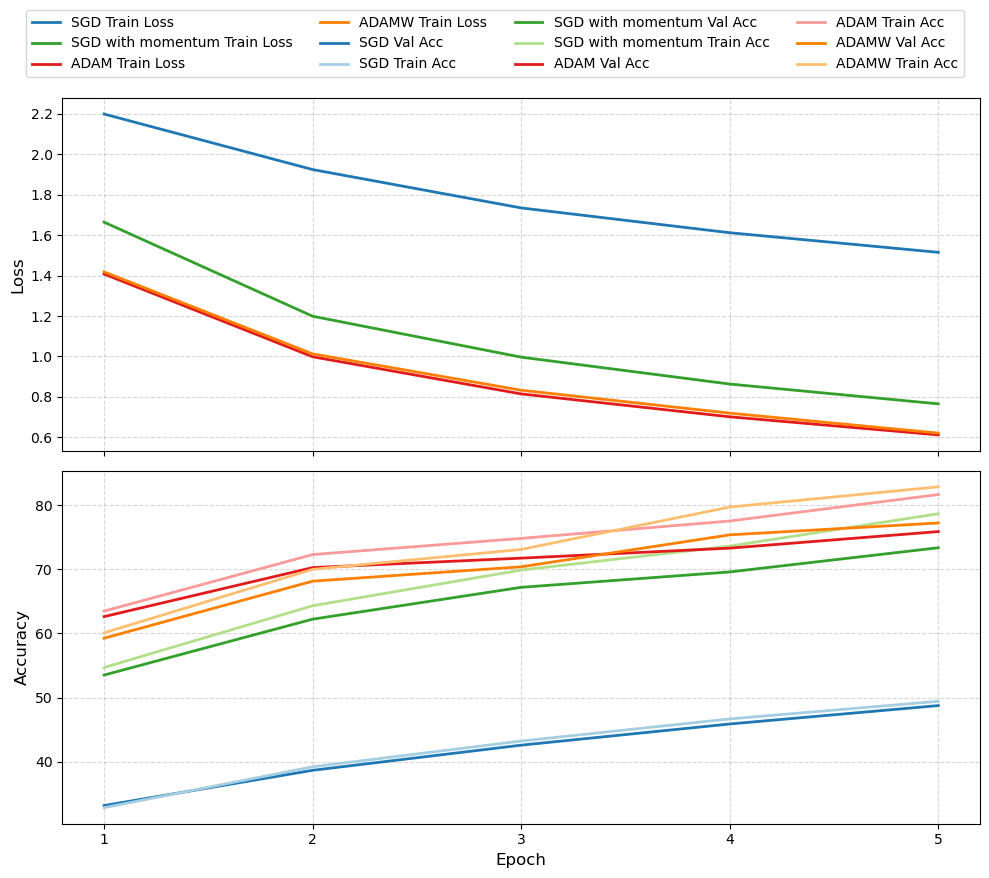

In [6]:
compare_losses(losses)

Ok, the best optimizer seems to be the ADAM. Let's try to search the best learning rate

In [7]:
lr_grid = np.logspace(-5, -2, 5)
epochs = 5

losses = []

for lr in lr_grid:
    print(f"Training with lr={lr}")
    model = SimpleCNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss, acc, train_acc = train_model(model, train_data, val_data, device, epochs=epochs, optimizer=optimizer)
    losses.append((lr, loss, acc, train_acc))
    print()

Training with lr=1e-05
[Epoch  1/5] Training Loss: 1.8977, Validation Accuracy: 43.99%, Training Accuracy: 44.68%, Time: 4.24s, lr: 0.000010
[Epoch  2/5] Training Loss: 1.5446, Validation Accuracy: 51.62%, Training Accuracy: 52.54%, Time: 4.26s, lr: 0.000010
[Epoch  3/5] Training Loss: 1.3855, Validation Accuracy: 55.77%, Training Accuracy: 57.23%, Time: 4.21s, lr: 0.000010
[Epoch  4/5] Training Loss: 1.2737, Validation Accuracy: 57.99%, Training Accuracy: 59.76%, Time: 4.22s, lr: 0.000010
[Epoch  5/5] Training Loss: 1.2001, Validation Accuracy: 60.29%, Training Accuracy: 62.66%, Time: 4.26s, lr: 0.000010

Training with lr=5.623413251903491e-05
[Epoch  1/5] Training Loss: 1.5218, Validation Accuracy: 57.49%, Training Accuracy: 59.27%, Time: 4.19s, lr: 0.000056
[Epoch  2/5] Training Loss: 1.1256, Validation Accuracy: 64.06%, Training Accuracy: 67.17%, Time: 4.33s, lr: 0.000056
[Epoch  3/5] Training Loss: 0.9594, Validation Accuracy: 67.37%, Training Accuracy: 72.56%, Time: 4.29s, lr: 0.

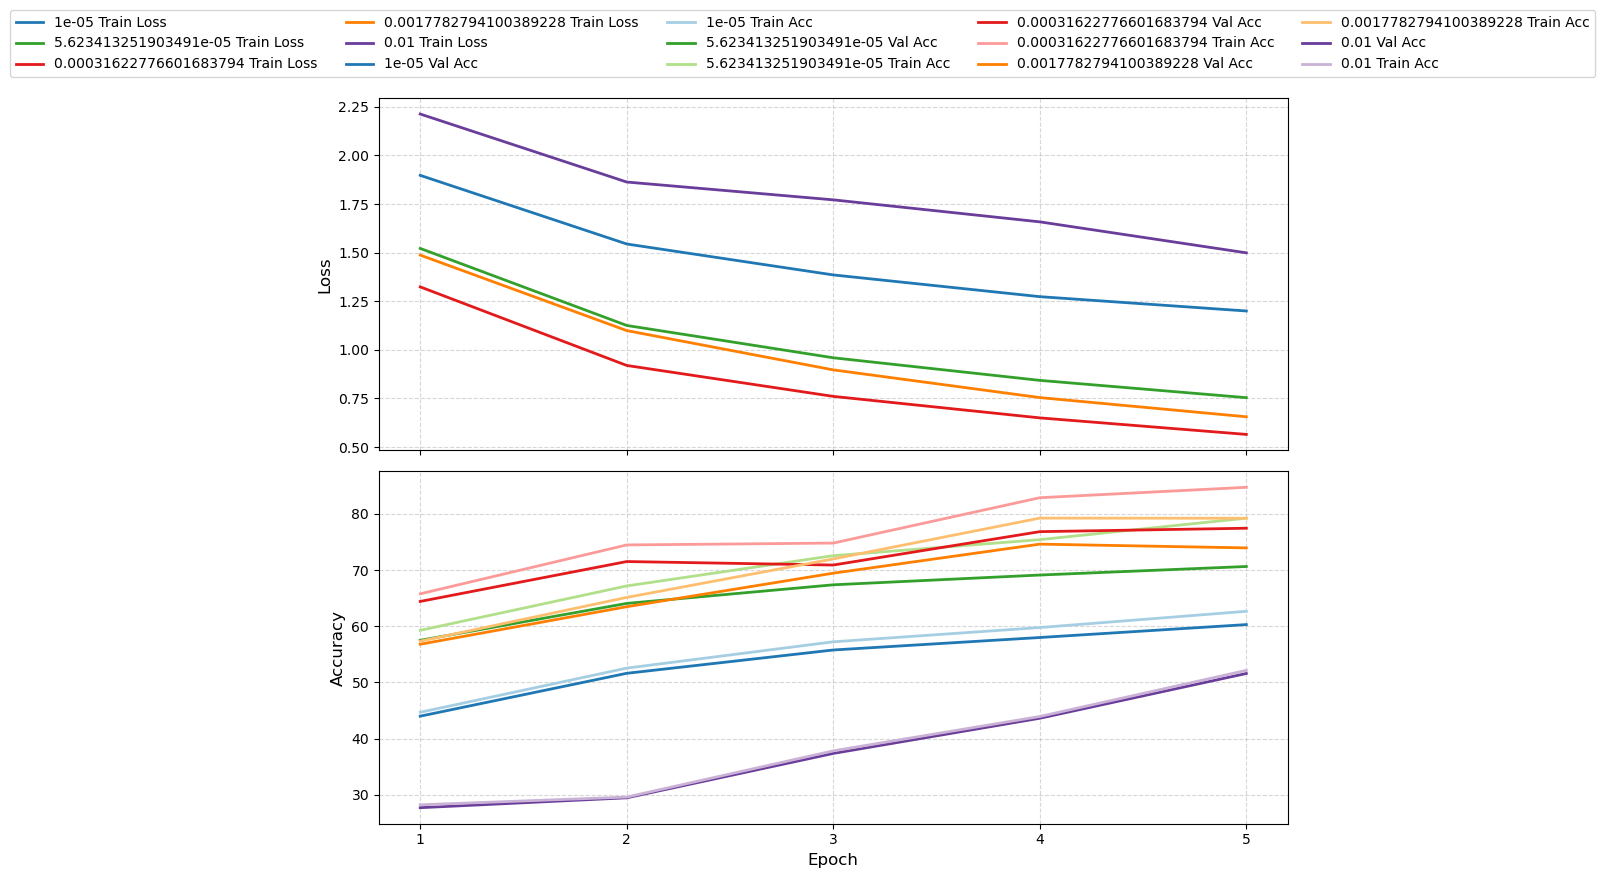

In [8]:
compare_losses(losses)

The optimal learning rate appears to be around $1 \times 10^{-3}$. However, it's important to note that these results are relative. The number of training epochs is far from ideal, and it's possible that a lower learning rate (e.g., $1 \times 10^{-5}$) could achieve significantly better accuracy given more training time. A more precise evaluation would require an extensive search with a larger number of epochs for each learning rate. Due to time and resource constraints, such an exhaustive search is not performed. Nevertheless, in the next steps, a learning rate scheduler will be introduced to dynamically adjust the learning rate during training.  

With that in place, it's time to experiment with the network architecture. The first step is to evaluate whether omitting the pooling layer between the 3rd and 4th convolutional layers was a good choice. Additionally, different configurations of layer sizes and parameters will be tested to further refine the model.

In [9]:
class CNNExtraPool(nn.Module):
    def __init__(self, output_dim=10):
        super(CNNExtraPool, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  

        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
class CNNExtraLayer(nn.Module):
    def __init__(self, output_dim=10):
        super(CNNExtraLayer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(512 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
class CNNParamChange(nn.Module):
    def __init__(self, output_dim=10):
        super(CNNParamChange, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [10]:
model = CNNExtraPool()
model = model.to('cuda')
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
      BatchNorm2d-11            [-1, 256, 4, 4]             512
        MaxPool2d-12            [-1, 256, 2, 2]               0
           Linear-13                  [-1, 512]         524,800
          Dropout-14                  [

In [11]:
model = CNNExtraLayer()
model = model.to('cuda')
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
      BatchNorm2d-11            [-1, 256, 4, 4]             512
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        MaxPool2d-14            [-1, 51

In [12]:
model = CNNParamChange()
model = model.to('cuda')
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          36,992
       BatchNorm2d-8            [-1, 128, 8, 8]             256
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Linear-12                  [-1, 256]       1,048,832
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [13]:
epochs = 10
lr = 0.001
losses = []

# SimpleCNN
print("SimpleCNN")
model = SimpleCNN()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_simple, acc_simple, acc_train_simple = train_model(
    model, train_data, val_data, device, epochs=epochs, optimizer=optimizer
)
print()

# CNNExtraPool
print("CNNExtraPool")
model = CNNExtraPool()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_extra_pool, acc_extra_pool, acc_train_extra_pool = train_model(
    model, train_data, val_data, device, epochs=epochs, optimizer=optimizer
)
print()

# CNNExtraLayer
print("CNNExtraLayer")
model = CNNExtraLayer()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_extra_layer, acc_extra_layer, acc_train_extra_layer = train_model(
    model, train_data, val_data, device, epochs=epochs, optimizer=optimizer
)
print()

# CNNParamChange
print("CNNParamChange")
model = CNNParamChange()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_param_change, acc_param_change, acc_train_param_change = train_model(
    model, train_data, val_data, device, epochs=epochs, optimizer=optimizer
)
print()

losses = [
    ("SimpleCNN", loss_simple, acc_simple, acc_train_simple),
    ("CNNExtraPool", loss_extra_pool, acc_extra_pool, acc_train_extra_pool),
    ("CNNExtraLayer", loss_extra_layer, acc_extra_layer, acc_train_extra_layer),
    ("CNNParamChange", loss_param_change, acc_param_change, acc_train_param_change),
]

SimpleCNN
[Epoch  1/10] Training Loss: 1.3945, Validation Accuracy: 58.43%, Training Accuracy: 58.76%, Time: 4.26s, lr: 0.001000
[Epoch  2/10] Training Loss: 0.9837, Validation Accuracy: 70.14%, Training Accuracy: 71.70%, Time: 4.19s, lr: 0.001000
[Epoch  3/10] Training Loss: 0.8090, Validation Accuracy: 70.18%, Training Accuracy: 73.52%, Time: 4.36s, lr: 0.001000
[Epoch  4/10] Training Loss: 0.7046, Validation Accuracy: 75.48%, Training Accuracy: 80.35%, Time: 4.28s, lr: 0.001000
[Epoch  5/10] Training Loss: 0.6131, Validation Accuracy: 77.60%, Training Accuracy: 84.01%, Time: 4.21s, lr: 0.001000
[Epoch  6/10] Training Loss: 0.5392, Validation Accuracy: 79.49%, Training Accuracy: 86.35%, Time: 4.27s, lr: 0.001000
[Epoch  7/10] Training Loss: 0.4705, Validation Accuracy: 79.90%, Training Accuracy: 88.14%, Time: 4.25s, lr: 0.001000
[Epoch  8/10] Training Loss: 0.4069, Validation Accuracy: 79.74%, Training Accuracy: 89.86%, Time: 4.18s, lr: 0.001000
[Epoch  9/10] Training Loss: 0.3532, V

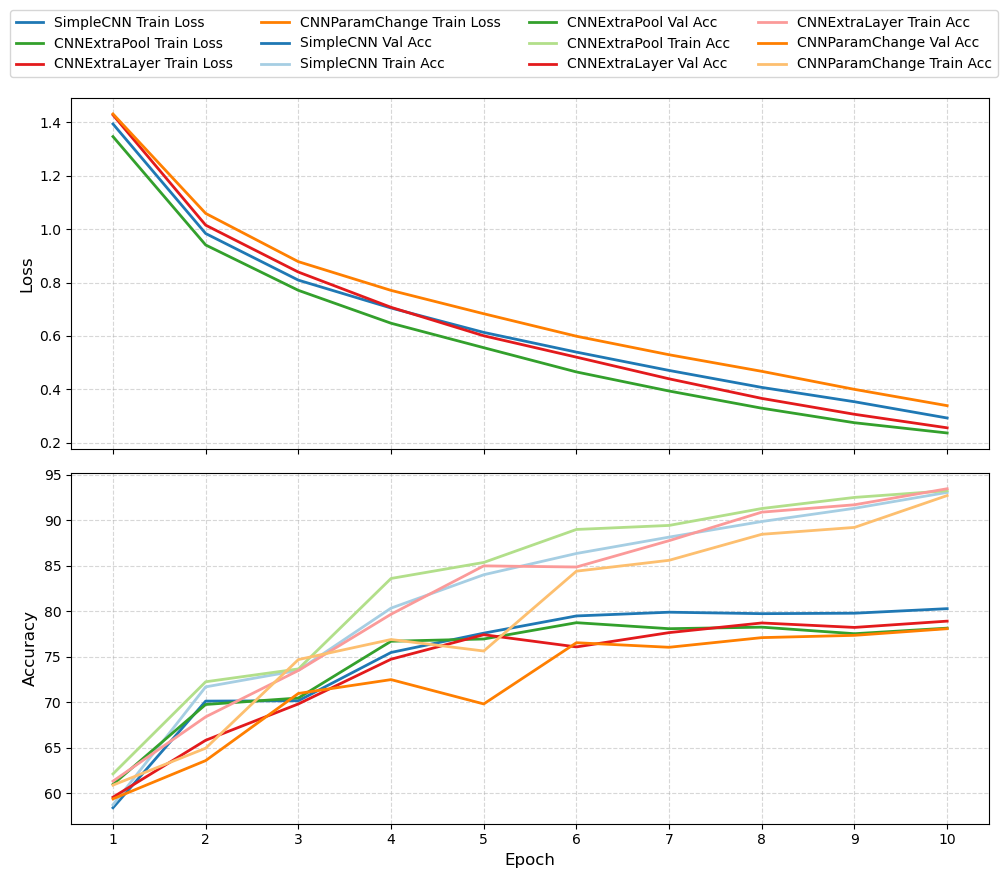

In [14]:
compare_losses(losses)

The best model seems to be the simplest one. So we'll keep it for the next steps. Let's see if with some data augmentation we can achieve a better result.

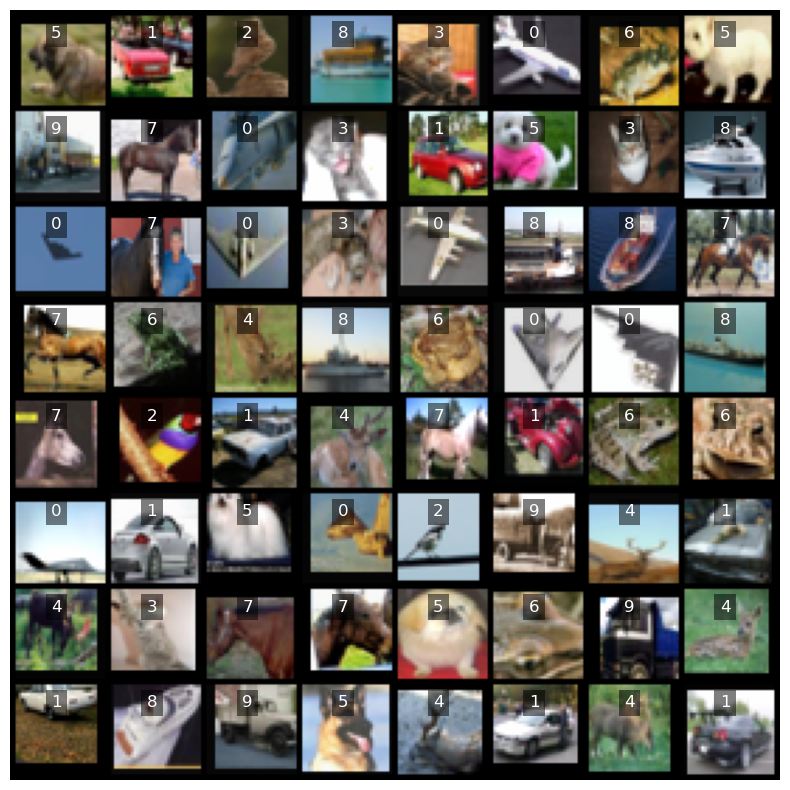

In [15]:
train_data_aug, val_data_aug = get_cifar10_dataloader(augment=True)
visualize_dataloader(train_data_aug)

In [16]:
epochs = 20
lr = 0.001

losses = []

# SimpleCNN no augmentation
print("SimpleCNN no augmentation")
model = SimpleCNN()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_simple, acc_simple, acc_train_simple = train_model(
    model, train_data, val_data, device, epochs=epochs, optimizer=optimizer
)
print()

# SimpleCNN with augmentation
print("SimpleCNN with augmentation")
model = SimpleCNN()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_simple_aug, acc_simple_aug, acc_train_simple_aug = train_model(
    model, train_data_aug, val_data_aug, device, epochs=epochs, optimizer=optimizer
)
print()

losses = [
    ("SimpleCNN no augmentation", loss_simple, acc_simple, acc_train_simple),
    ("SimpleCNN with augmentation", loss_simple_aug, acc_simple_aug, acc_train_simple_aug),
]

SimpleCNN no augmentation
[Epoch  1/20] Training Loss: 1.3894, Validation Accuracy: 55.98%, Training Accuracy: 55.47%, Time: 4.33s, lr: 0.001000
[Epoch  2/20] Training Loss: 0.9818, Validation Accuracy: 67.37%, Training Accuracy: 69.54%, Time: 4.30s, lr: 0.001000
[Epoch  3/20] Training Loss: 0.8181, Validation Accuracy: 73.23%, Training Accuracy: 76.32%, Time: 4.19s, lr: 0.001000
[Epoch  4/20] Training Loss: 0.7090, Validation Accuracy: 75.17%, Training Accuracy: 78.87%, Time: 4.24s, lr: 0.001000
[Epoch  5/20] Training Loss: 0.6115, Validation Accuracy: 77.14%, Training Accuracy: 83.26%, Time: 4.27s, lr: 0.001000
[Epoch  6/20] Training Loss: 0.5326, Validation Accuracy: 76.40%, Training Accuracy: 82.95%, Time: 4.27s, lr: 0.001000
[Epoch  7/20] Training Loss: 0.4602, Validation Accuracy: 78.11%, Training Accuracy: 87.03%, Time: 4.30s, lr: 0.001000
[Epoch  8/20] Training Loss: 0.4024, Validation Accuracy: 79.54%, Training Accuracy: 89.84%, Time: 4.34s, lr: 0.001000
[Epoch  9/20] Training

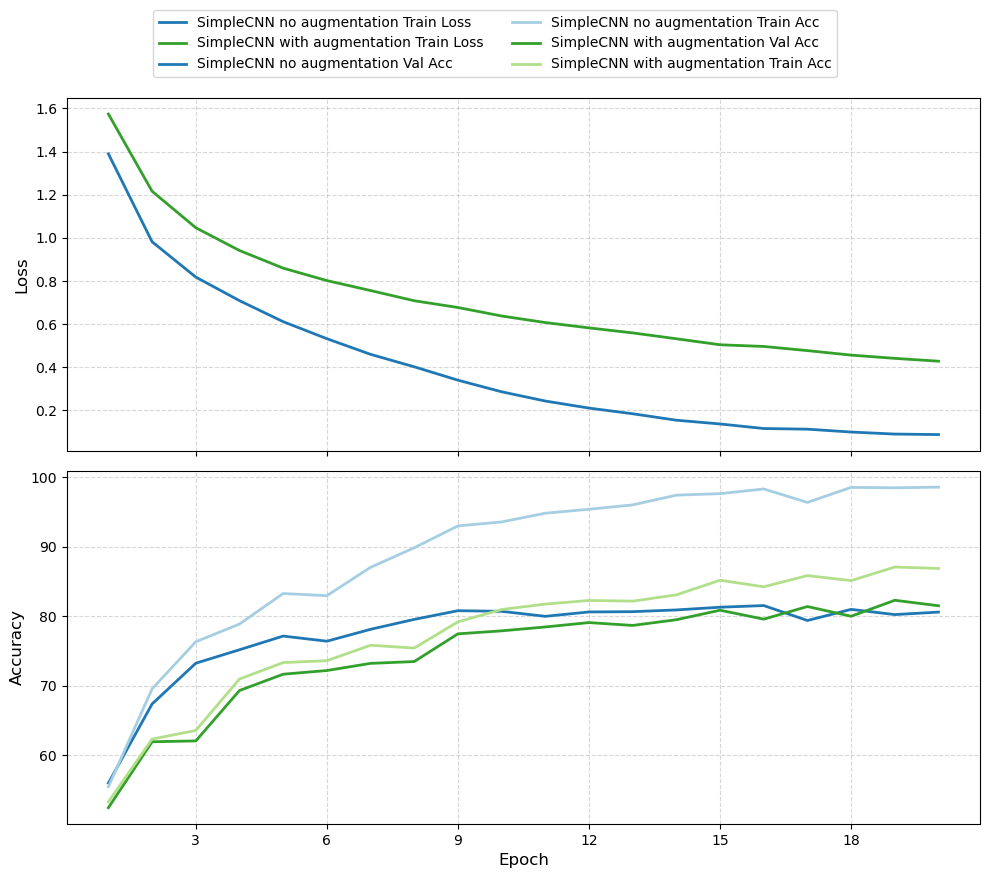

In [17]:
compare_losses(losses)  

Even if the net trained without data augmentation performed better in most of the epochs, the one trained with data augmentation will probably be more general for different test data.

Now, we can try to achieve an higher performance by augmenting the number of epochs and add a scheduler to change dynamically the learning rate. Furthermore, also the early stopping technique will be applied to avoid useless training time.

In [18]:
class FinalCNN(nn.Module):
    def __init__(self, output_dim=10):
        super(FinalCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  

        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = FinalCNN()
model = model.to('cuda')
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Linear-12                  [-1, 512]       2,097,664
          Dropout-13                  [-1, 512]               0
           Linear-14                  [

In [19]:
epochs = 60
lr = 0.001

losses = []

# SimpleCNN with augmentation
print("FinalCNN")
model = FinalCNN()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
loss_simple_aug, acc_simple_aug, acc_train_simple_aug = train_model(
    model, train_data_aug, val_data_aug, device, epochs=epochs, optimizer=optimizer, scheduler=scheduler
)

losses = [
    ("FinalCNN", loss_simple_aug, acc_simple_aug, acc_train_simple_aug),
]

save_model(model, "FinalCNN_reduceOnPlateau_60epochs")

FinalCNN


/home/filippoquadri/miniconda3/envs/dlav/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch  1/60] Training Loss: 1.6456, Validation Accuracy: 46.00%, Training Accuracy: 46.43%, Time: 9.77s, lr: 0.001000
[Epoch  2/60] Training Loss: 1.3156, Validation Accuracy: 59.06%, Training Accuracy: 59.38%, Time: 9.68s, lr: 0.001000
[Epoch  3/60] Training Loss: 1.1400, Validation Accuracy: 63.67%, Training Accuracy: 64.17%, Time: 9.83s, lr: 0.001000
[Epoch  4/60] Training Loss: 1.0295, Validation Accuracy: 67.82%, Training Accuracy: 69.23%, Time: 9.71s, lr: 0.001000
[Epoch  5/60] Training Loss: 0.9484, Validation Accuracy: 67.64%, Training Accuracy: 69.21%, Time: 9.67s, lr: 0.001000
[Epoch  6/60] Training Loss: 0.8872, Validation Accuracy: 72.32%, Training Accuracy: 73.69%, Time: 9.73s, lr: 0.001000
[Epoch  7/60] Training Loss: 0.8269, Validation Accuracy: 73.86%, Training Accuracy: 75.42%, Time: 9.77s, lr: 0.001000
[Epoch  8/60] Training Loss: 0.7830, Validation Accuracy: 73.51%, Training Accuracy: 75.23%, Time: 9.76s, lr: 0.000500
[Epoch  9/60] Training Loss: 0.6830, Validation 

'models/FinalCNN_reduceOnPlateau_60epochs.pth'

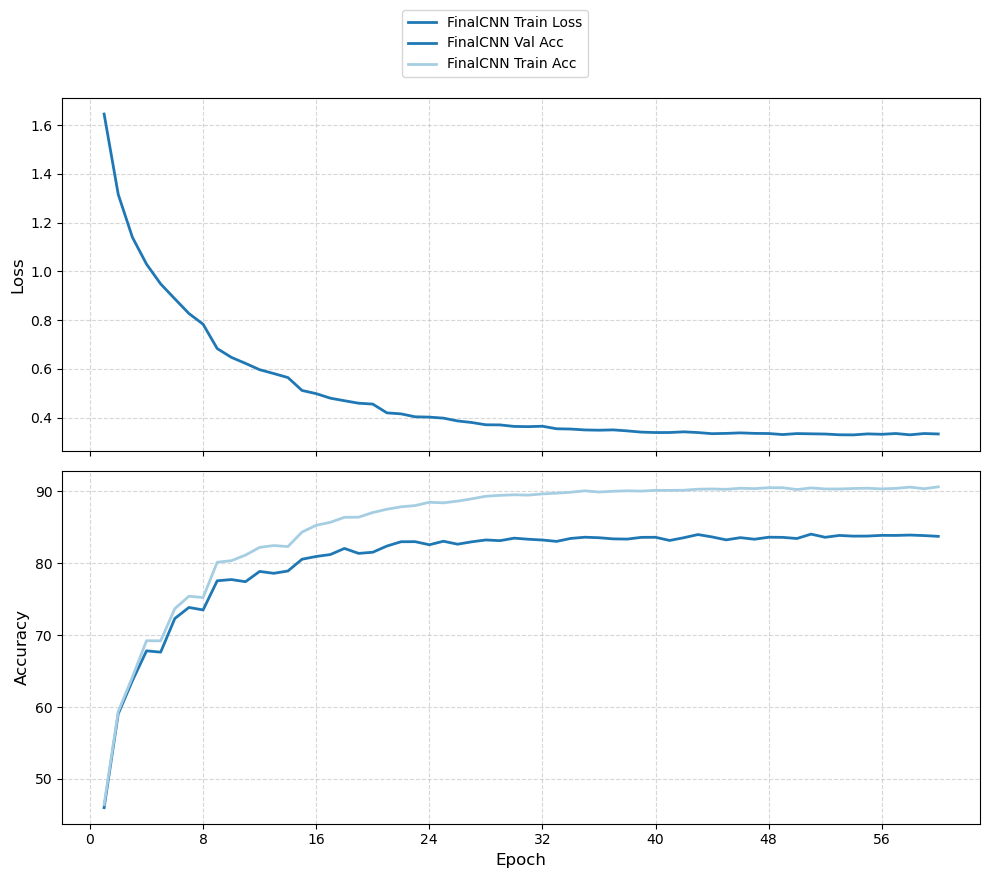

In [20]:
compare_losses(losses)

In [21]:
class FinalCNNAugmented(nn.Module):
    def __init__(self, output_dim=10):
        super(FinalCNNAugmented, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = FinalCNNAugmented()
model = model.to('cuda')
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
      BatchNorm2d-11            [-1, 256, 4, 4]             512
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        MaxPool2d-14            [-1, 51

In [22]:
epochs = 100
lr = 0.001

losses = []

# SimpleCNN with augmentation
print("FinalCNNAugmented")
model = FinalCNNAugmented()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
loss_simple_aug, acc_simple_aug, acc_train_simple_aug = train_model(
    model, train_data_aug, val_data_aug, device, epochs=epochs, optimizer=optimizer, scheduler=scheduler, early_stopping=True
)

losses = [
    ("FinalCNNAugmented", loss_simple_aug, acc_simple_aug, acc_train_simple_aug),
]

save_model(model, "FinalCNNAugmented_reduceOnPlateau_100epochs")

FinalCNNAugmented
Using early stopping with patience 10.
[Epoch  1/100] Training Loss: 1.6043, Validation Accuracy: 50.71%, Training Accuracy: 51.40%, Time: 9.81s, lr: 0.001000
[Epoch  2/100] Training Loss: 1.2147, Validation Accuracy: 53.25%, Training Accuracy: 54.92%, Time: 9.73s, lr: 0.001000
[Epoch  3/100] Training Loss: 1.0491, Validation Accuracy: 63.45%, Training Accuracy: 63.73%, Time: 9.81s, lr: 0.001000
[Epoch  4/100] Training Loss: 0.9417, Validation Accuracy: 69.41%, Training Accuracy: 70.73%, Time: 9.84s, lr: 0.001000
[Epoch  5/100] Training Loss: 0.8560, Validation Accuracy: 71.55%, Training Accuracy: 73.11%, Time: 9.77s, lr: 0.001000
[Epoch  6/100] Training Loss: 0.8038, Validation Accuracy: 70.31%, Training Accuracy: 72.08%, Time: 9.70s, lr: 0.001000
[Epoch  7/100] Training Loss: 0.7540, Validation Accuracy: 74.10%, Training Accuracy: 76.25%, Time: 9.80s, lr: 0.000500
[Epoch  8/100] Training Loss: 0.6378, Validation Accuracy: 77.84%, Training Accuracy: 80.05%, Time: 9.7

'models/FinalCNNAugmented_reduceOnPlateau_100epochs.pth'

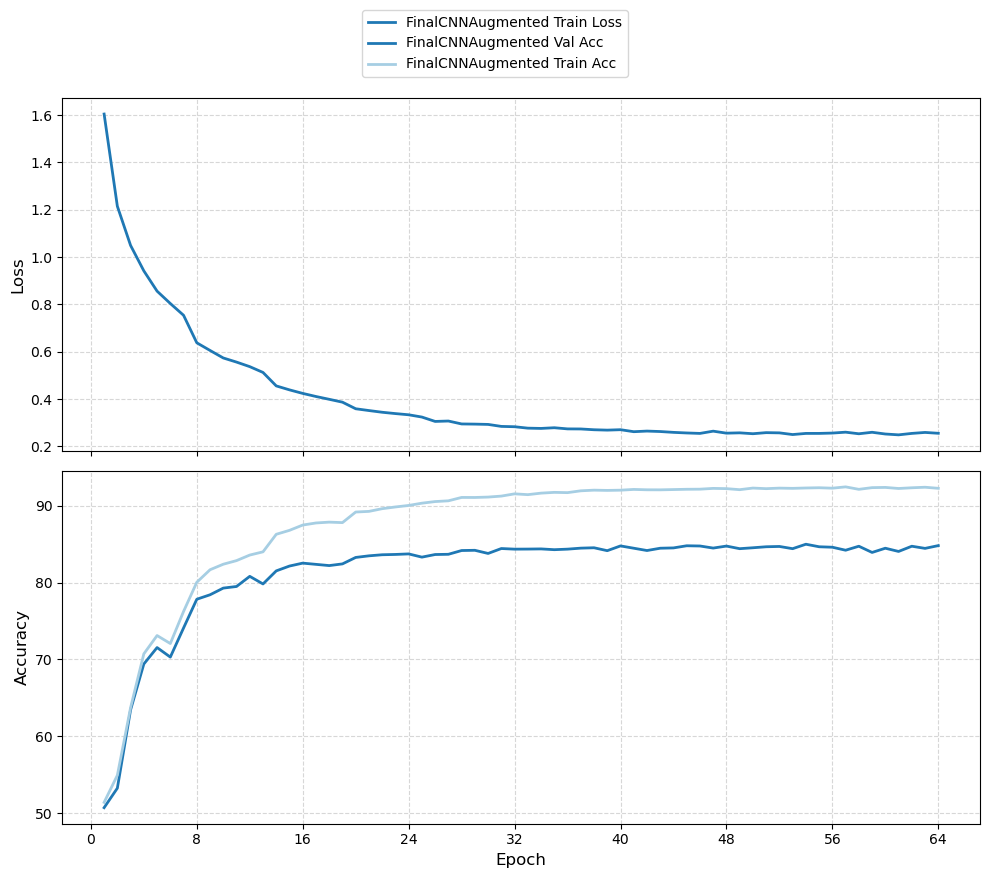

In [23]:
compare_losses(losses)

In [24]:
epochs = 100
lr = 0.001

losses = []

# SimpleCNN with augmentation
print("FinalCNNAugmented")
model = FinalCNNAugmented()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
loss_simple_aug, acc_simple_aug, acc_train_simple_aug = train_model(
    model, train_data_aug, val_data_aug, device, epochs=epochs, optimizer=optimizer, scheduler=scheduler, early_stopping=True
)

losses = [
    ("FinalCNNAugmented", loss_simple_aug, acc_simple_aug, acc_train_simple_aug),
]

save_model(model, "FinalCNNAugmented_stepLR_100epochs")

FinalCNNAugmented
Using early stopping with patience 10.
[Epoch  1/100] Training Loss: 1.6304, Validation Accuracy: 49.69%, Training Accuracy: 49.94%, Time: 9.72s, lr: 0.001000
[Epoch  2/100] Training Loss: 1.2461, Validation Accuracy: 58.19%, Training Accuracy: 58.51%, Time: 9.75s, lr: 0.001000
[Epoch  3/100] Training Loss: 1.0728, Validation Accuracy: 59.18%, Training Accuracy: 60.10%, Time: 9.87s, lr: 0.001000
[Epoch  4/100] Training Loss: 0.9741, Validation Accuracy: 68.39%, Training Accuracy: 69.68%, Time: 9.77s, lr: 0.001000
[Epoch  5/100] Training Loss: 0.8825, Validation Accuracy: 69.04%, Training Accuracy: 70.64%, Time: 9.79s, lr: 0.001000
[Epoch  6/100] Training Loss: 0.8209, Validation Accuracy: 72.43%, Training Accuracy: 74.19%, Time: 9.87s, lr: 0.001000
[Epoch  7/100] Training Loss: 0.7699, Validation Accuracy: 72.69%, Training Accuracy: 74.84%, Time: 9.75s, lr: 0.001000
[Epoch  8/100] Training Loss: 0.7192, Validation Accuracy: 74.92%, Training Accuracy: 77.15%, Time: 9.7

'models/FinalCNNAugmented_stepLR_100epochs.pth'

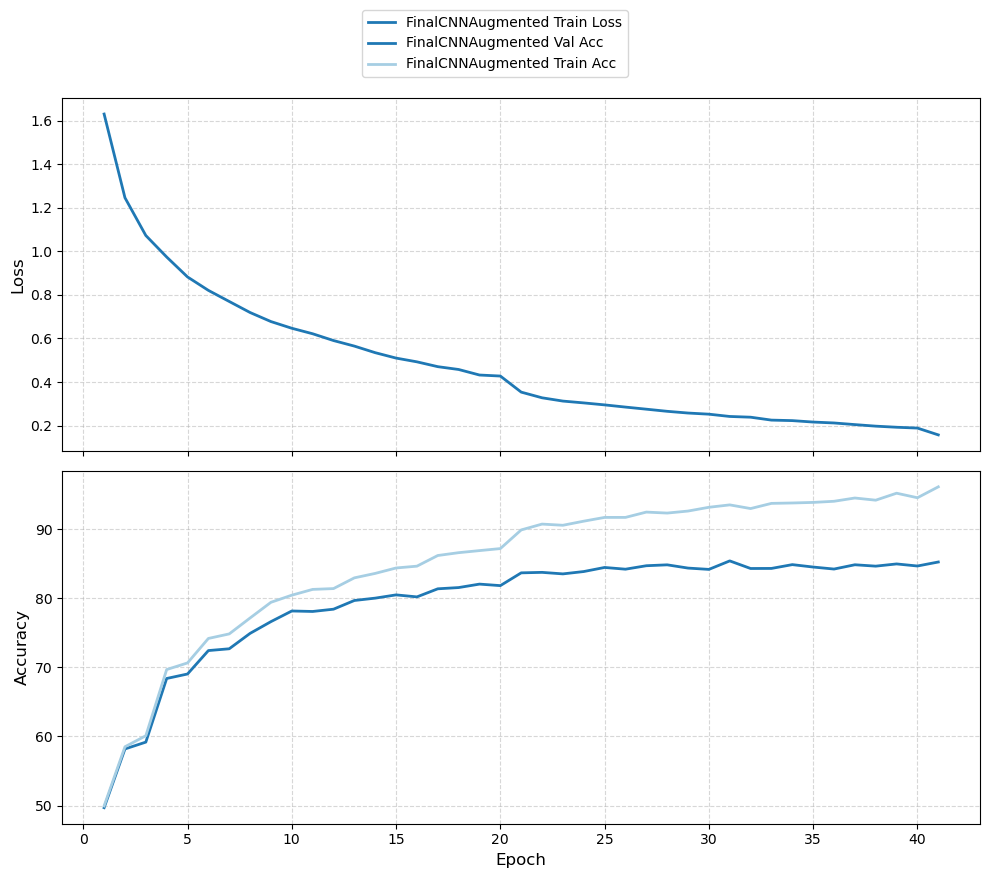

In [25]:
compare_losses(losses)

In [26]:
class FinalCNNExtraAugmented(nn.Module):
    def __init__(self, output_dim=10):
        super(FinalCNNExtraAugmented, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))

        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = FinalCNNExtraAugmented()
model = model.to('cuda')
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
      BatchNorm2d-11            [-1, 256, 4, 4]             512
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
           Conv2d-14            [-1, 51

In [27]:
epochs = 100
lr = 0.001

losses = []

# SimpleCNN with augmentation
print("FinalCNNExtraAugmented")
model = FinalCNNExtraAugmented()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
loss_simple_aug, acc_simple_aug, acc_train_simple_aug = train_model(
    model, train_data_aug, val_data_aug, device, epochs=epochs, optimizer=optimizer, scheduler=scheduler, early_stopping=True
)

losses = [
    ("FinalCNNExtraAugmented", loss_simple_aug, acc_simple_aug, acc_train_simple_aug),
]

save_model(model, "FinalCNNExtraAugmented_stepLR_100epochs")

FinalCNNExtraAugmented
Using early stopping with patience 10.
[Epoch  1/100] Training Loss: 1.6789, Validation Accuracy: 35.96%, Training Accuracy: 37.03%, Time: 9.90s, lr: 0.001000
[Epoch  2/100] Training Loss: 1.3281, Validation Accuracy: 55.34%, Training Accuracy: 55.59%, Time: 9.77s, lr: 0.001000
[Epoch  3/100] Training Loss: 1.1435, Validation Accuracy: 60.19%, Training Accuracy: 61.28%, Time: 9.87s, lr: 0.001000
[Epoch  4/100] Training Loss: 1.0201, Validation Accuracy: 66.89%, Training Accuracy: 67.77%, Time: 9.82s, lr: 0.001000
[Epoch  5/100] Training Loss: 0.9356, Validation Accuracy: 68.92%, Training Accuracy: 70.41%, Time: 9.81s, lr: 0.001000
[Epoch  6/100] Training Loss: 0.8700, Validation Accuracy: 69.37%, Training Accuracy: 70.58%, Time: 9.90s, lr: 0.001000
[Epoch  7/100] Training Loss: 0.8141, Validation Accuracy: 73.52%, Training Accuracy: 75.60%, Time: 9.79s, lr: 0.001000
[Epoch  8/100] Training Loss: 0.7631, Validation Accuracy: 73.95%, Training Accuracy: 76.14%, Time

'models/FinalCNNExtraAugmented_stepLR_100epochs.pth'

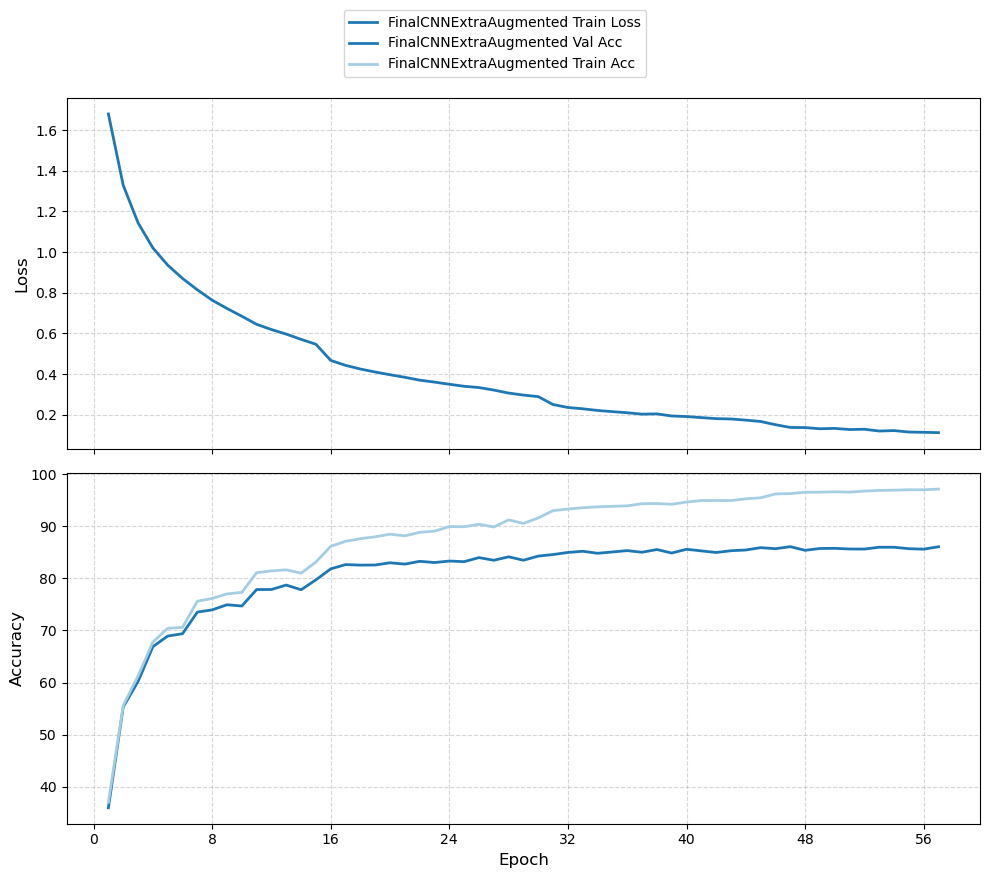

In [28]:
compare_losses(losses)